## MNIST classification

In this notebook we tackle the perhaps most well known problem in all of machine learning, classifying hand-written digits. In particular, we will use the MNIST (Modified National Institute of Standards and Technology) dataset. The digits are 28x28 pixel images that look somewhat like this:

![](https://user-images.githubusercontent.com/2202312/32365318-b0ccc44a-c079-11e7-8fb1-6b1566c0bdc4.png)

Each digit has been hand classified, e.g. for the above 9-7-0-9-0-...

Our task is to teach a neural network to perform this classification, i.e. we want to find a function $\mathcal{T}_\theta$ such that

| | |
|-|-|
|$\mathcal{T}_\theta$(|<img align="center" src="https://user-images.githubusercontent.com/2202312/33177374-b134e572-d062-11e7-87c7-0574c6f5bee9.png" width="28"/>|) = 4|

# Import dependencies

This should run without errors if all dependencies are installed properly. However you may get some warnings, these are typically safe to ignore

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tensorflow.examples.tutorials.mnist import input_data

# Introduction to Tensorflow

In these exercies we'll use the software library [Tensorflow](https://www.tensorflow.org/), which is a state of the art library for numerical computations in python developed by Google. The package supports computation on both the CPU and GPU, and also supports automatic differentiation (more on that later).

### Execution
Writing code in tensorflow is quite similar to classical python, except for one thing: tensorflow uses *deferred execution*, this means that instead of executing the code in one step (called eager execution), the computational graph is first defined, and it is then fed data upon which the computation is performed. Users from compiled languages will recongnize this execution method.

The execution flow typically goes like this:

* Define placeholders for the input
* Define what computations should be performed
* Feed the placeholders data

In small examples like this, this may seem very cumbersome. The computational model has several upsides that are sadly not evident in simple samples like these, including parallelization, packaging and optimization. However once you start working on larger examples these become more evident.

### Name scopes
Tensorflow also uses scopes (e.g. [`tf.name_scope`](https://www.tensorflow.org/api_docs/python/tf/name_scope)) to organize the code. This can interact very nicely with external tools like [tensorboard](https://www.tensorflow.org/get_started/summaries_and_tensorboard), but is also used as comments in the code and to give better error messages.

### Batched computation
Finally, tensorflow (and most other deep learning libraries) uses batched execution. This means that instead of computing the result one element at a time, or one image at a time, the result is computed simultaneously for a *batch* of images, e.g. several. The batch size is typically in the range of 1 to 512, depending on the input size. This is done in order to enable faster computations on modern hardware. Due to this, the shape of objects used with tensorflow is typically

```
[BATCH_SIZE, ...]
```

### Sessions

Tensorflow uses *sessions* to encapuslate computations. These can be useful when running on e.g. multiple GPUs. For simple examples like this, an `InteractiveSession` works well.

In [2]:
# Start a tensorflow session
session = tf.InteractiveSession()

# Set the random seed to enable reproducible code
np.random.seed(42)
tf.set_random_seed(42)

# MNIST data

We now need to get the data we will use, which in this case is the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a set of 65000 hand-written digits.


In order to not cheat, it is best practice in machine learning to train on one set (conveniently called the "train" set) and evaluate on another, called the "test"-set. If the method performs well on the test dataset, we can expect it to perform well on other unseen datasets as well.

In the standard split of the MNIST data, 55000 datapoints are used for training and 10000 for testing.

### Get MNIST data

Luckily for us, there is an easy to use tool for working the MNIST dataset in `tensorflow.examples.tutorials.mnist.input_data` that we previously imported.

This utility downloads the data if needed and also provides utilities for accessing the training and testing sets as well as for getting small minibatches for training.

In [3]:
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


### Inspect data

In machine learning, the first step is **always** to try to understand your data. How does it look? What pre-processing has been done?

In this case we can [read the documentation](http://yann.lecun.com/exdb/mnist/) to find:

* The images were rescaled to size 20 x 20
* The numbers are all fit in a 28 x 28 square and centered according to center of mass $\approx [14, 14]$
* the values span exactly $[0, 1]$.
* The numbers are from $\approx 250$ writers and scrambled in order

In general, documentation is always feeble (perhaps the data has been modified in our data loader?), and it may be a good idea to verify these statements yourself. To do this, we look at the first datapoint in the test set. It is labeled as a "7", and visually this seems to be true. Likewise, the center of mass does indeed seem to be at $\approx [14, 14]$. We also note that the values are *inverted* (white on black background).

center of mass = (14.383709839842643, 14.340846509159318)
min value = 0.0, max value = 1.0


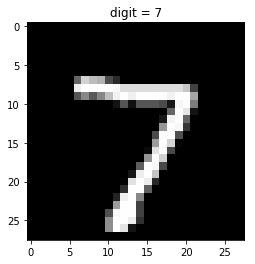

In [4]:
img = mnist.test.images[0].reshape(28, 28)
value =  mnist.test.labels[0]
print('center of mass = {}'.format(scipy.ndimage.measurements.center_of_mass(img)))
print('min value = {}, max value = {}'.format(np.min(img), np.max(img)))
plt.imshow(img, cmap='Greys_r');
plt.title('digit = {}'.format(value))
plt.show()

### Objective function

Before we start defining methods, we must first settle on a definition of what it meas for a method to be good. Doing this is non-trivial for a range of tasks, and depending on our choice of "goodness" we may obtain different "best" methods.

In the setting of classification, we would ideally like to learn a function $f$ such that $f(x) = n$ where $x$ is the image and $n$ the corresponding digit, and we would like this to hold for *any* image. Such a loss function could be written
$$
    L(f) = \int I(f(x) \neq n) d\mu(x, n)
$$
where $\mu(x, n)$ is the probability density of images $x$ and labels $n$, and $I$ is the indicator function.

However, we only have access to the training set (55000 images/labels) and thus there is no way for us compute the integral. Hence we will use the Empirical Risk Minimization (ERM) paradigm, wherein we assume that we have Independent Identically Distributed (I.I.D.) samples $(x_i, n_i)$ from $\mu$ and define the best function by minimization of the empirical risk
$$
    \hat{L}(f) = \frac{1}{N} \sum_{i = 1}^N I(f(x_i) \neq n_i)
$$

Finally, even if our function $f$ is good on the training set, we do not know if it is good on unseen data (e.g. we don't know if it generalizes). For example, the function
$$
    f(x) =
    \begin{cases}
        n_i & \text{ if } x = x_i\\
        0 & \text{ else.}
    \end{cases}
$$
has 0 empirical risk, but is obviously a really bad classifier (it is correct with probability zero).

To validate that our classifier works on unseen data, we also apply it to the test dataset. The function below computes the empirical test error.

In [5]:
# Get all the images and labels from the test set
batch = mnist.test.next_batch(10000)
test_images = batch[0].reshape([-1, 28, 28, 1])
test_labels = batch[1]

def test_error(result_tensor, data_placeholder):
    """Evaluate a reconstruction method by computing the % correct.

    Parameters
    ----------
    result_tensor : `tf.Tensor`, shape (None,)
        The tensorflow tensor containing the result of the classification.
    data_placeholder : `tf.Tensor`, shape (None, 28, 28, 1) or (None, 784)
        The tensorflow tensor containing the input to the classification operator.

    Returns
    -------
    MSE : float
        Mean squared error of the reconstruction.
    """
    feed_images = np.reshape(test_images, [-1, *data_placeholder.shape[1:]])
    result = result_tensor.eval(
        feed_dict={data_placeholder: feed_images})

    return np.mean(result == test_labels)

# Logistic regression

As stated above, the loss function was defined for *any* classifier $f$, but for computational feasibility we typically need to constrain our selves to some set of functions parametrized by some parameters $\{f_\theta\}_{\theta \in \Theta}$.

The most simple nontrivial method is the linear regression
$$
    f_\theta(x)
    =
    \text{argmax}_{i \in \{0, \dots, 9\}}
    \big(\langle w_i, x \rangle + b_i\big)
$$
where $\theta = (w_0, \dots w_9, b_0, \dots, b_9)$, $w_i \in \mathbb{R}^{28 \times 28}$ and $b_i \in \mathbb{R}$.

However, even for this very simple classifier, we find that solving the optimization problem $\min \hat{L}(\theta)$ is  basically impossible, and this is since we cannot compute the gradient
$$
    \frac{\partial \hat{L}(\theta)}{\partial \theta}
$$
and this problem does in fact apply to any loss function that involves the exact classification error.

A solution to this is to forfeit the idea of minimizing the classification error and instead minimize some *surrogate*. An exceedingly popular such surrogate is to compute a probability distribution for each image. For example, for the linear regression above we could define the probability of image $x$ corresponding to the number $n$ by
$$
f_\theta(x, n) = \frac{\exp\big(\langle w_n, x \rangle + b_n\big)}{\sum_{j=0}^9 \exp\big(\langle w_j, x \rangle + b_j\big)}
$$
However, the question then becomes: what is a good loss function? Since we now have functions that return probabilities, a good choice of a loss function would be to minimize the some probability distance between the estimated probabilities and the true probabilities.

One such metric is the Kullback-Leibler distance which gives
\\[
L(\theta) = -\frac{1}{N}\sum_{i=1}^N\sum_{n=0}^9 I(n_i = n) \log(f_\theta(x_i, n))
\\]
Regression with this method is called [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), and it is perhaps the most well known and widely applied classification method.

### Elementary Implementation of logistic regression

We start with an elementary implementation of logistic regression in `TensorFlow`. This is to show how `TensorFlow` works "under the hood", and does *not* reflect how one typically writes tensorflow code.

Here there are a few components we'll use:

* [`tf.placeholder`](https://www.tensorflow.org/api_docs/python/tf/placeholder) is as it sounds a placeholder for some value we will later provide. Here we use `shape=(None, 784)` where `None` indicates that this value is not a-priori determined, we can use any number. $784$ is simply $28 \times 28$.
* [`tf.Variable`](https://www.tensorflow.org/api_docs/python/tf/Variable) is something (in fact the only thing) that can change its value over time. This will be there parameters $\theta$ that we minimize over. We also provide initial values, normally distributed for the weights and zero for the bias.

We then compute the logarithmic probabilities according to the formulae above

In [6]:
with tf.name_scope('elementary_network'):
    # Create a placeholder for our input data (no computation is done here)
    inp = tf.placeholder(shape=(None, 784), dtype=tf.float32, name="input")
    
    # Create the parameters (weight, bias) of the model
    weights = tf.Variable(tf.random_normal((784, 10)), name="weights")
    bias = tf.Variable(tf.zeros((10)), name="bias")
    
    # Compute the probabilities (this is all lazy, no computations are actually performed)
    lin = tf.matmul(inp, weights) + bias
    elin = tf.exp(lin)
    Z = tf.reduce_sum(elin, axis=1, keep_dims=True)
    prob = elin / Z
    log_prob = tf.log(prob)
    
    # Prediction by the most likely digit
    pred = tf.argmax(log_prob, axis=1)  # axis 0 is the batch, axis 1 is the labels

### Loss function

Define the loss function which measures how good our parameters are, recall:
\\[
    L(\theta) = -\frac{1}{N}\sum_{i=1}^N\sum_{n=0}^9 I(n_i = n) \log(f_\theta(x_i, n))
\\]

In order to convert from labels to probabilities, we use the one-hot-encoding, which can be seen as computing the true probabilities of each digit:

In [21]:
toh = tf.one_hot([1, 1, 2], depth=10)
toh.eval()

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [8]:
with tf.name_scope("elementary_loss"):
    labels = tf.placeholder(shape=(None,), dtype=tf.int32)
    determ = tf.one_hot(labels, depth=10)
    loss = -tf.reduce_mean(tf.reduce_sum(determ * log_prob, axis=1))

### Training step

We'll train the network using gradient descent, i.e.

$$\theta \leftarrow \theta - \omega \nabla L(\theta)$$

where $\omega$ is the *learning rate*, or step size.

Note that in machine learning, we typically use *stochastic* gradient descent (SGD). In these methods we don't use all of the data to compute the gradient, only a small subset called a minibatch. Here we use 128 images in each minibatch.

Further, while for this case computing the gradient would be quite simple, once we move to harder and more complicated models doing so would be basically impossible to do by hand. To work around this, all major deep learning frameworks implement [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). This may sound fancy, but automatic differentiation is simply the chain rule for the adjoint of the derivative derivative:

$$
[D(g \circ f)(x)]^*(y) = [Df(x)]^*\big([Dg(f(x))]^*(y)\bigr)
$$

Tensorflow implements it using the [`tf.gradients`](https://www.tensorflow.org/api_docs/python/tf/gradients) command.

As noted above, `tf.Variable`s are the only mutable objects in tensorflow and we'll use that to update them in place using the `var.assign` method. Note that we still do not actually perform this operation, we're only building the computational graph.

In [9]:
with tf.name_scope("elementary_training"):
    learning_rate = .1

    variables = [weights, bias]
    gradients = tf.gradients(loss, variables)
    update_ops = [var.assign(var - learning_rate*grad) 
                  for var, grad in zip(variables, gradients)]

### Initialization

Since all the code above was lazy, nothing has actually happened. Before we start we need to initialize the variables. This causes the (normally distributed) initializer of `weights` to run, setting its initial values.

In [10]:
init = tf.global_variables_initializer().run()

### Run the training

We train the network by feeding data from the training set and occationally evalute the performance on our test set, this is the first point we actually start doing computations

In [11]:
for i in range(10000):
    inp_, labels_ = mnist.train.next_batch(128)
    session.run(update_ops, 
                feed_dict={labels:labels_, inp:inp_})
    
    if i % 1000 == 999:
        print("{:.1f}%, ".format(test_error(pred, inp)*100), end="")

80.6%, 84.4%, 86.0%, 87.0%, 87.5%, 87.8%, 88.1%, 88.5%, 88.7%, 89.0%, 

## Using TensorFlow libraries

While the above code solves our problem, it involved several small and perhaps obscure steps. Once we start moving to more complicated neural networks the code would become very repetetive.

Since all of the steps are standardized, we can (and should) instead use built in tensorflow functions, this example does that, and all following examples will do the same.

### Network

The "network" can be computed using the [`tf.contrib.layers.fully_connected`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected) function which computes

$$\rho(Wx + b)$$

where $\rho$ is the activation function, $W$ is a matrix called the weights and $b$ is a real vector called the bias. Note that here we never explicitly construct these, they are hidden inside tensorflow.

Also remember that above we needed to give an initializer to the weights and biases, this is now done automatically (but can be modified via the `weights_initializer` and `bias_initializer` parameters.) However in this case we'll just use defaults. If we check the defaults, this means

* `weights_initializer=`[`tf.contrib.layers.xavier_initializer`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer). This is a rather smart initializer, which basically choses the weights such that the norm of the input and output is approximately equal, which gives more stable training.
* `bias_initializer=`[`tf.zeros_initializer`](https://www.tensorflow.org/api_docs/python/tf/zeros_initializer). Which does exactly what you expect it to do.

In [12]:
with tf.name_scope('logistic_regression'):
    logits = tf.contrib.layers.fully_connected(inp, 
                                               num_outputs=10,      # We only need to specify the number of outputs
                                               activation_fn=None)  # Dont use any activation (include in loss instead)
    pred = tf.argmax(logits, axis=1)

### Loss and optimization

The loss function defined above should be done using the [`tf.nn.softmax_cross_entropy_with_logits`](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) function, which not only is easier to use, it is also more numerically stable (once again a reason to use libraries).

In addition to this, we don't really have to write our own optimizer, and there are in fact several very good optimizers built into tensorflow. In this example we'll use [`tf.train.AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) which is a very popular and efficient gradient-based optimizer. All of the details regarding weights etc are hidden inside tensorflow.

In [13]:
with tf.name_scope('optimizer'):
    one_hot_labels = tf.one_hot(labels, depth=10)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_labels,
                                                   logits=logits)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [14]:
session.run(tf.global_variables_initializer())

### Train the network

Training the network looks about the same as above except this is now much faster due to better initialization and because we use a better optimizer.

In [15]:
# Initialize all TF variables
for i in range(10000):
    inp_, labels_ = mnist.train.next_batch(128)
    session.run(optimizer, 
                feed_dict={labels:labels_, inp:inp_})

    if i % 1000 == 999:
        print("{:.1f}%, ".format(test_error(pred, inp)*100), end="")

91.5%, 92.2%, 92.3%, 92.6%, 92.6%, 92.8%, 92.6%, 92.8%, 92.7%, 92.7%, 

# Multilayer Perceptron

The first "deep" neural networks were [multilayer perceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron). In these we have a function of the following form

$$
W_3\rho(W_2\rho(W_1 x + b_1) + b_2) + b_3
$$

Where $W_i \in \mathbb{R}^{n_{i - 1} \times n_{i}}$ are matrices and $b_i \in \mathbb{R}^{n_{i}}$ vectors and $\rho$ a pointwise nonlinearity $\mathbb{R}^{n_{i}} \to \mathbb{R}^{n_{i}}$.

Note that the logistic regression can be cast into this form (how?).

In this very simple neural network we'll use the following parameters:

* Network size:
  * `n_0=784` ($28 \times 28$)
  * `n_1=128`
  * `n_2=32`
  * `n_3=10` (number of labels)
* ReLU nonlinearities $\rho$
$$
ReLU(x) = \max(x, 0)
$$

Thanks to the utilities defined above implementing this network is very straightforward.

In [16]:
with tf.name_scope('logistic_regression'):
    x = tf.contrib.layers.fully_connected(inp, num_outputs=128)  # the default activation function is ReLU
    x = tf.contrib.layers.fully_connected(x, num_outputs=32)
    logits = tf.contrib.layers.fully_connected(x, 
                                               num_outputs=10,
                                               activation_fn=None)
    pred = tf.argmax(logits, axis=1)
    
with tf.name_scope('optimizer'):
    one_hot_labels = tf.one_hot(labels, depth=10)
    
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_labels,
                                                   logits=logits)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

# Initialize all TF variables
session.run(tf.global_variables_initializer())

for i in range(10000):
    inp_, labels_ = mnist.train.next_batch(128)
    session.run(optimizer, 
                feed_dict={labels:labels_, inp:inp_})

    if i % 1000 == 999:
        print("{:.1f}%, ".format(test_error(pred, inp)*100), end="")

96.0%, 97.4%, 97.7%, 97.7%, 97.6%, 97.8%, 97.1%, 97.5%, 97.8%, 97.7%, 

# Convolutional network

Convolutional neural networks are a corner-stone of the deep learning revolution. Here instead of using traditionall fully-connected layers which connect each point with all other points, we use spatial convolutions instead. By doing this, we get a translation invariant operator that acts locally. 

A convolution operator $C : \mathcal{X}^n \to \mathcal{X}^m$, where $\mathcal{X}$ is some set of images and $n$ is called the number of channels, is defined by
$$
[C(x)]_i = \sum_j (w_{ij} \ast x_j + b_j)
$$
where the *weight* $w_{ij}$ is a convolution kernel and $b_j \in \mathbb{R}$ is the bias.

In applications, there number of duplicate entries $n, m$ is typically $\in [32, 512]$ and the convolution kernel is given by a small $e.g. 3 \times 3$ stencil. We'll use the built in function [`tf.contrib.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d) in order to perform the convolutions efficiently. Specifically this function operates on arrays with shape `[batch, height, width, channels]`, which is called BHWC order. Do note that this is not universal and e.g. PyTorch uses BCHW order.

In order to get non-local behaviour we stack several of these on top of each other in the same manner as a MLP.

The following code is a very simplified convolutional neural network for digit classification with the following layers

* `3x3` convolution with 32 channels and and ReLU nonlinearity.
* `2x2` maxpooling to reduce the dimension.
* `3x3` convolution with 32 channels and and ReLU nonlinearity.
* `2x2` maxpooling.
* Flatten the images and channels to a one-dimensional array
* $1568 \to 128$ fully connected layer with ReLU nonlinearity
* $128 \to 10$ fully connected layer


In [17]:
with tf.name_scope('convolutional_network'):
    # Reshape the input from [?, 784] to [?, 28, 28, 1] where 1 is the number of channels (e.g. n above)
    images = tf.reshape(inp, [-1, 28, 28, 1])
    
    x = tf.contrib.layers.conv2d(images, 
                                 num_outputs=32, # Number of "channels", e.g. duplicates of the image
                                 kernel_size=3)  # size of the convolution kernel
    x = tf.contrib.layers.max_pool2d(x, 
                                     kernel_size=[2, 2])  # Size of strides
    # x.shape = [?, 14, 14, 32]
    x = tf.contrib.layers.conv2d(x, num_outputs=32, kernel_size=3)
    x = tf.contrib.layers.max_pool2d(x, kernel_size=[2, 2])
    # x.shape = [?, 7, 7, 32]
    x = tf.contrib.layers.flatten(x)    
    # x.shape = [?, 1568]
    
    # It is typically a good idea to finish with fully connected layers 
    # in order to encode the non-translation invariant information
    x = tf.contrib.layers.fully_connected(x, 128)
    logits = tf.contrib.layers.fully_connected(x, 10,
                                               activation_fn=None)
    pred = tf.argmax(logits, axis=1)
    
with tf.name_scope('optimizer'):
    one_hot_labels = tf.one_hot(labels, depth=10)
    
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_labels,
                                                   logits=logits)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

# Initialize all TF variables
session.run(tf.global_variables_initializer())

for i in range(10000):
    inp_, labels_ = mnist.train.next_batch(32)
    session.run(optimizer, 
                feed_dict={labels:labels_, inp:inp_})

    if i % 1000 == 999:
        print("{:.1f}%, ".format(test_error(pred, inp)*100), end="")

98.0%, 98.6%, 98.4%, 98.7%, 98.9%, 99.1%, 99.0%, 98.9%, 99.1%, 98.9%, 

# Conclusions

From this notebook there are some take-aways

* A classification problem involves taking an image and assigning it to a class (e.g. 4)
* Several methods from machine learning can be used for classificication
* Software libraries like tensorflow are great
* Deeper neural networks work very well
* Convolutions allow us to encode spatial information